
##**Text Emotion Classification**
## **Name: Noor Ul Ain Khurshid**


# 1.0 Load Dataset

Dataset is from:
https://huggingface.co/datasets/dair-ai/emotion

In [172]:
!pip install datasets
from datasets import load_dataset

emotion_dataset = load_dataset("emotion")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/3 [00:00<?, ?it/s]

In [173]:
emotion_train = emotion_dataset['train']
print(emotion_train[0])
print(emotion_train.column_names)
print(emotion_train.features)

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [174]:
import pandas as pd
emotion_dataset.set_format(type="pandas")
train = emotion_dataset["train"][:]
test = emotion_dataset["test"][:]
val = emotion_dataset["validation"][:]

In [175]:
dataset = pd.concat([train, test, val], axis=0)

In [176]:
len(dataset)

20000

In [177]:
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [178]:
def get_name(label):
    return names[label]

dataset["emotion"] = dataset["label"].map(get_name)

In [179]:
dataset.head()

,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


#2.0 Data Overview/EDA

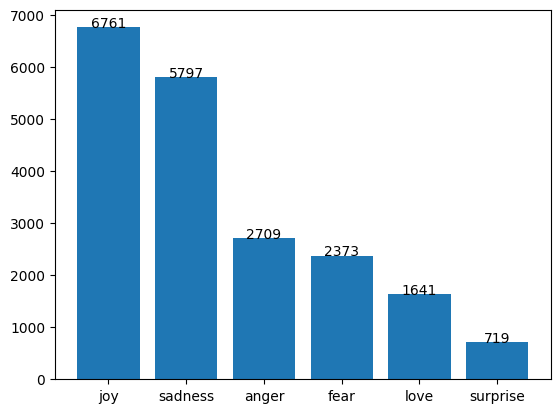

In [180]:
import matplotlib.pyplot as plt

emotion = dataset["emotion"].value_counts()
plt.bar(emotion.index, emotion.values)

for i, v in enumerate(emotion.values):
    plt.text(i, v, str(v), color='black', ha="center")

plt.show()

([<matplotlib.patches.Wedge at 0x7f84af206e60>,
 [Text(0.5358242191644744, 0.9606728923815752, 'joy'),
  Text(-1.0937124393622855, 0.11744402915516555, 'sadness'),
  Text(-0.36854448991788274, -1.0364241211739371, 'anger'),
  Text(0.485019021914126, -0.9872975986912279, 'fear'),
  Text(0.9738348294354211, -0.511513171852382, 'love'),
  Text(1.0929919364588851, -0.1239702659344418, 'surprise')],
 [Text(0.2922677559078951, 0.5240033958444955, '33.8%'),
  Text(-0.5965704214703375, 0.0640603795391812, '29.0%'),
  Text(-0.201024267227936, -0.5653222479130565, '13.5%'),
  Text(0.2645558301349778, -0.5385259629224879, '11.9%'),
  Text(0.5311826342375023, -0.2790071846467538, '8.2%'),
  Text(0.5961774198866646, -0.06762014505515006, '3.6%')])

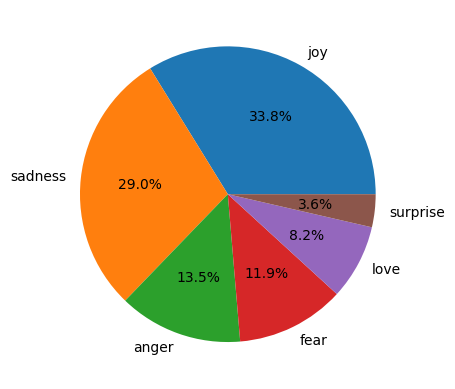

In [181]:
emotions = dataset["emotion"].value_counts()
plt.pie(emotions.values, labels=emotions.index, autopct='%1.1f%%')

There is a large discrepency between the values, with the most common emotion, joy (6761) being more than 9 times larger than than the smallest, surprise (719). This mmight cause a skew in results towards joy since it has more data to train on, so as a precaution I will be reducing all of the emotions counts to match surprise's

([<matplotlib.patches.Wedge at 0x7f84af4191b0>,
 [Text(0.9526279355804298, 0.5500000148652441, 'sadness'),
  Text(-5.149471629032507e-08, 1.0999999999999988, 'joy'),
  Text(-0.9526279870751434, 0.5499999256737774, 'love'),
  Text(-0.952627884085708, -0.5500001040567056, 'anger'),
  Text(1.5448414935947287e-07, -1.0999999999999892, 'fear'),
  Text(0.9526280385698485, -0.5499998364823061, 'surprise')],
 [Text(0.5196152375893253, 0.30000000810831495, '16.7%'),
  Text(-2.8088027067450036e-08, 0.5999999999999993, '16.7%'),
  Text(-0.5196152656773508, 0.299999959458424, '16.7%'),
  Text(-0.5196152095012951, -0.30000005675820307, '16.7%'),
  Text(8.426408146880338e-08, -0.5999999999999941, '16.7%'),
  Text(0.5196152937653719, -0.29999991080853056, '16.7%')])

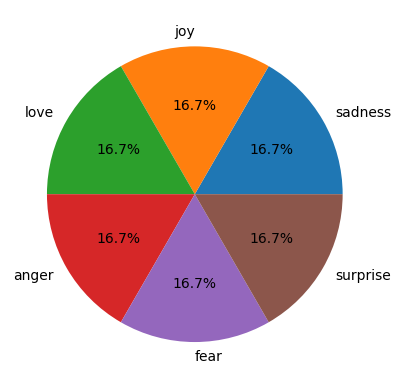

In [182]:
min_records = dataset["emotion"].value_counts().min()

dataset = dataset.groupby("label").apply(lambda x: x.sample(min_records))

emotions = dataset["emotion"].value_counts()
plt.pie(emotions.values, labels=emotions.index, autopct='%1.1f%%')

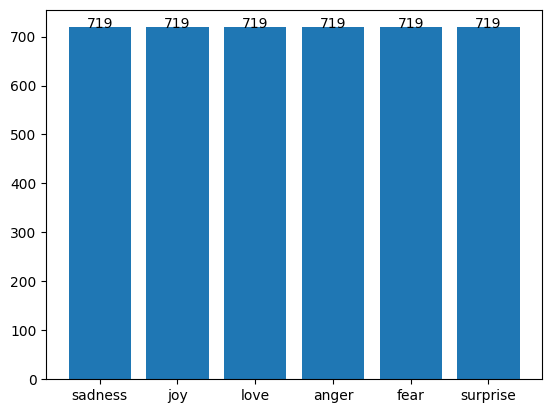

In [183]:
emotion = dataset["emotion"].value_counts()
plt.bar(emotion.index, emotion.values)

for i, v in enumerate(emotion.values):
    plt.text(i, v, str(v), color='black', ha="center")

plt.show()

In [184]:
dataset = dataset.sample(frac=1, random_state=27).reset_index(drop=True)
dataset.head()

,text,label,emotion
0,i even feel weird living with lay people again,5,surprise
1,i feel i should as a gracious gesture apologiz...,2,love
2,i notice i jump when i feel anything in my hai...,5,surprise
3,i feel like if you can t admit that you ve alw...,5,surprise
4,i feel youre faithful over me as i sing amp wo...,2,love


#3.0 Preprocessing (Tokenization + Vectorization [Word Embeddings])

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.utils import tokenize
import string
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [186]:
def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

def clean_the_tweet_gensim(text):
  tokens= list(tokenize(text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens)

In [187]:
dataset['cleaned_tweet'] = dataset['text'].apply(clean_the_tweet_gensim)
dataset['cleaned_tweet_new'] = dataset['cleaned_tweet'].apply(text_process)
dataset.reset_index(drop=True, inplace = True)

In [188]:
dataset.head()

,text,label,emotion,cleaned_tweet,cleaned_tweet_new
0,i even feel weird living with lay people again,5,surprise,i even feel weird living with lay people again,even feel weird living lay people
1,i feel i should as a gracious gesture apologiz...,2,love,i feel i should as a gracious gesture apologiz...,feel gracious gesture apologizing latest post ...
2,i notice i jump when i feel anything in my hai...,5,surprise,i notice i jump when i feel anything in my hai...,notice jump feel anything hair cant say im sur...
3,i feel like if you can t admit that you ve alw...,5,surprise,i feel like if you can t admit that you ve alw...,feel like admit always little bit weird little...
4,i feel youre faithful over me as i sing amp wo...,2,love,i feel youre faithful over me as i sing amp wo...,feel youre faithful sing amp worship find word...


In [189]:
nltk.download('punkt')
dataset['tokens'] = dataset['cleaned_tweet_new'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [190]:
selected_cols = ['text', 'label', 'tokens']
dataset = dataset[selected_cols]
dataset.head()

,text,label,tokens
0,i even feel weird living with lay people again,5,"[even, feel, weird, living, lay, people]"
1,i feel i should as a gracious gesture apologiz...,2,"[feel, gracious, gesture, apologizing, latest,..."
2,i notice i jump when i feel anything in my hai...,5,"[notice, jump, feel, anything, hair, cant, say..."
3,i feel like if you can t admit that you ve alw...,5,"[feel, like, admit, always, little, bit, weird..."
4,i feel youre faithful over me as i sing amp wo...,2,"[feel, youre, faithful, sing, amp, worship, fi..."


In [191]:
import numpy as np
from tensorflow import keras as keras
import tensorflow as tf

#A helper module to handle padding input
from keras.preprocessing import sequence

#The base Keras neural network model
from keras.models import Sequential

#The layer objects you’ll pile into the model
from keras.layers import Dense, Dropout, Activation, Flatten

#Your convolution layer, and pooling
from keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 4.0 Classification (Building Classifier & Training)

In [192]:
train, test = train_test_split(dataset, test_size=0.4, random_state=63)

In [193]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['tokens'])
train_sequences = tokenizer.texts_to_sequences(train['tokens'])
test_sequences = tokenizer.texts_to_sequences(test['tokens'])

# Pad sequence for all tokens to have same length

# Vectorization to make words to numbers
max_length = max(len(seq) for seq in train_sequences)
train_data = pad_sequences(train_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)

# Prepare the target labels
train_labels = train['label']
test_labels = test['label']


In [194]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64))
model.add(Dense(6, activation='sigmoid'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
metrics=['accuracy'])

history= model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=50, batch_size=32, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 34, 128)           715264    
                                                                 
 conv1d_18 (Conv1D)          (None, 32, 64)            24640     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_18 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dense_37 (Dense)            (None, 6)               

# 5.0 Results

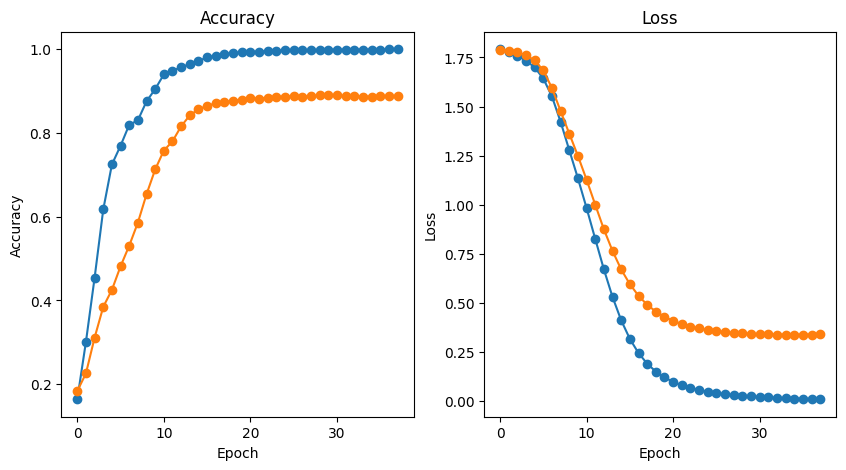

In [195]:
#Plotting the accuracy and loss of both the models 
plt.figure(figsize=(10, 5))
# Plot training accuracy with a line
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], '-o')  # Add a line connecting the dots
plt.plot(history.history['val_accuracy'], '-o')  

# Plot training loss with a line
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], '-o')  # Add a line connecting the dots
plt.plot(history.history['val_loss'], '-o')  

plt.show()

In [196]:
model.save('/content/drive/MyDrive/emotion_model.h5')

In [197]:
predictions = model.predict(test_data)

# Initialize an empty array to store the predicted class labels
predicted_labels = np.zeros(predictions.shape[0], dtype=np.int32)

# Loop through each sample and find the index of the maximum value
for i in range(predictions.shape[0]):
    predicted_labels[i] = np.argmax(predictions[i])

print(predicted_labels[:10])

54/54 [==============================] - 0s 2ms/step
[1 1 4 2 2 4 4 1 2 5]


In [198]:
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [199]:
test_emotions = []
pred_emotions = []
for x in test_labels:
  test_emotions.append(names[x])

for x in predicted_labels:
  pred_emotions.append(names[x])

test_emotions[:10]
pred_emotions[:10]

['joy',
 'joy',
 'fear',
 'love',
 'love',
 'fear',
 'fear',
 'joy',
 'love',
 'surprise']

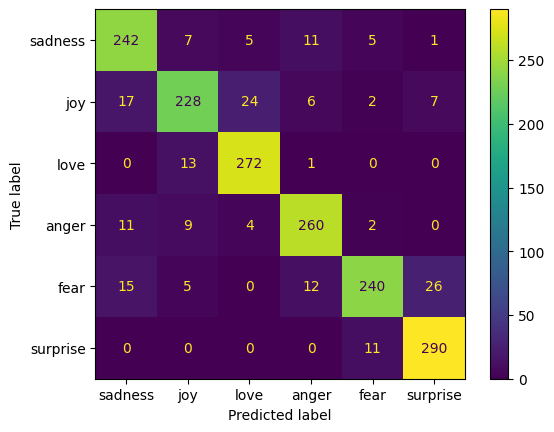

In [200]:
#Building a confusion Matrix to check the accuracy of the model 
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix_m1 = metrics.confusion_matrix(test_labels, predicted_labels)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_m1, display_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

cm_display.plot()

plt.show()

In [211]:
test_tweets =pd.read_csv('predict.csv')
test_tweets

,Link,Tweet,Emotion,label
0,https://twitter.com/ArsenalN7/status/165551025...,Tackle of the season from Xhaka. Wow🔥,joy,1
1,https://twitter.com/FunnyMan_02/status/1655767...,"Just finished Guardians Of The Galaxy 3, was r...",joy,1
2,https://twitter.com/MenzeliciousAF/status/1655...,MY MOM IS CANCER FREE IM GONNA CRY IM SO RELIE...,joy,1
3,https://twitter.com/wizard0rb/status/165573940...,had to factory reset my ipad today which means...,sadness,0
4,https://twitter.com/iihtishamm/status/16559404...,This footage is breaking my heart 💔,sadness,0
5,https://twitter.com/sadtweetsN1/status/1652844...,i hate random sad days. having a heavy heart a...,sadness,0
6,https://twitter.com/Drebae_/status/16538723022...,This AI sht don’t scare y’all??? It’s progress...,fear,4
7,https://twitter.com/AdewaleYusuf_/status/16555...,Google sent me my travel history report. I don...,fear,4
8,https://twitter.com/notmadoka/status/165525675...,BRO IVE NEVER BEEN THIS FRIGHTENED AT A GAME B...,fear,4
9,https://twitter.com/aghayford/status/165350407...,Every match day is a defeat day.Stop acting li...,anger,3


In [212]:
test_tweets['cleaned_tweet'] = test_tweets['Tweet'].apply(clean_the_tweet_gensim)
test_tweets['cleaned_tweet_new'] = test_tweets['cleaned_tweet'].apply(text_process)
test_tweets.reset_index(drop=True, inplace = True)

In [213]:
test_tweets['tokens'] = test_tweets['cleaned_tweet_new'].apply(nltk.word_tokenize)

In [214]:
selected_cols = ['Tweet', 'label', 'tokens']
test_tweets = test_tweets[selected_cols]
test_tweets.head()

,Tweet,label,tokens
0,Tackle of the season from Xhaka. Wow🔥,1,"[tackle, season, xhaka, wow]"
1,"Just finished Guardians Of The Galaxy 3, was r...",1,"[finished, guardians, galaxy, really, amazing,..."
2,MY MOM IS CANCER FREE IM GONNA CRY IM SO RELIE...,1,"[mom, cancer, free, im, gon, na, cry, im, reli..."
3,had to factory reset my ipad today which means...,0,"[factory, reset, ipad, today, means, original,..."
4,This footage is breaking my heart 💔,0,"[footage, breaking, heart]"


In [215]:
test_tweet_sequences = tokenizer.texts_to_sequences(test_tweets['tokens'])

test_tweet_sequences = pad_sequences(test_tweet_sequences, maxlen=max_length)

In [218]:
test_predictions = model.predict(test_tweet_sequences)

1/1 [==============================] - 0s 53ms/step


In [219]:
test_tweet1 = np.zeros(test_predictions.shape[0], dtype=np.int32)

# Loop through each sample and find the index of the maximum value
for i in range(test_predictions.shape[0]):
    test_tweet1[i] = np.argmax(test_predictions[i])

print(test_tweet1[:10])

[3 5 1 0 3 4 1 5 4 1]


In [ ]:
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [228]:
test_tweet_labels = test_tweets['label']

test_tweet_pred = []
test_tweet_actual =[]

for x in test_tweet1:
  test_tweet_pred.append(names[x])

for x in test_tweet_labels:
  test_tweet_actual.append(names[x])

print(test_tweet_pred)
print(test_tweet_actual)

['anger', 'surprise', 'joy', 'sadness', 'anger', 'fear', 'joy', 'surprise', 'fear', 'joy', 'sadness', 'anger', 'joy', 'sadness', 'joy', 'surprise', 'anger', 'anger']
['joy', 'joy', 'joy', 'sadness', 'sadness', 'sadness', 'fear', 'fear', 'fear', 'anger', 'anger', 'anger', 'love', 'love', 'love', 'surprise', 'surprise', 'surprise']


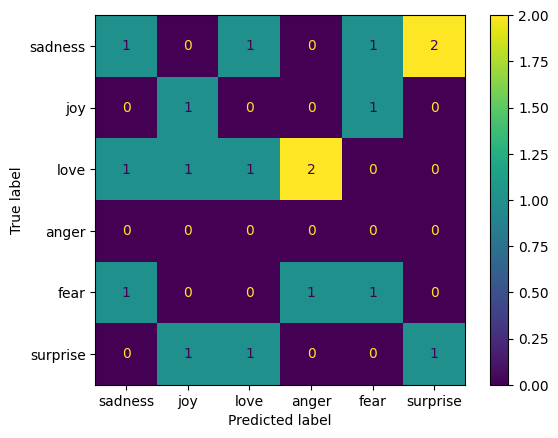

In [229]:
confusion_matrix_m2 = metrics.confusion_matrix(test_tweet_pred, test_tweet_actual)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_m2, display_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

cm_display.plot()

plt.show()